# Random Forest Regression Analysis of AllState Data Set

1. Load the competition training data set C_train and testing data set C_test and preprocess them in a combined Pandas data frame.
1. Generate a random subsample S (without replacement) of the training set C_train, such that the size of S is manageable.
1. Randomly split this subsample S into a training sample S_train and a test sample S_test.
1. Fit random forest regressor to S_train, using mean absolute error (mae) as criterion.
1. Save/retrieve random forest model to/from file.
1. Apply model to test sample S_test and measure performance.
1. Iterate steps 4 and 6 until a satisfactory result emerges.
1. Apply model to C_train\S (i.e. the complement of S inside C_train) and verify performance.
1. Compute predictions on C_test and output a submission file for the competition.
1. Produce some plots describing the analysis.

In [1]:
'''
Set run parameters here.
'''
preProc     = 1
N_train     = 15000
N_test      = 15000
nTrees      = 250
mxDepth     = 20
mnSleaf     = 5
mxfeat      = 0.3333

# Encode file name for various outputs
if mxfeat=="sqrt":
    runOptions = '_{0}_mxftsqr_{1:02d}K'.format(preProc,N_train/1000)
    fName      = '{0}_{1}_{2}_{3}'.format(runOptions, mxDepth, mnSleaf, nTrees)
elif mxfeat==0.3333:
    runOptions = '_{0}_mxft1o3_{1:02d}K'.format(preProc,N_train/1000)
    fName      = '{0}_{1}_{2}_{3}'.format(runOptions, mxDepth, mnSleaf, nTrees)
elif mxfeat=="auto":
    runOptions = '_{0}_mxftauto_{1:02d}K'.format(preProc,N_train/1000)
    fName      = '{0}_{1}_{2}_{3}'.format(runOptions, mxDepth, mnSleaf, nTrees)
else:
    print('Invalid mxfeat option {0}'.format(mxfeat))
    fName      = ''
    

print('fName = "{0}"'.format(fName))

fName = "_1_mxft1o3_15K_20_5_250"


In [2]:
'''
- Load and preprocess the AllState training data.
- Each row consists of one index, 116 categorical predictors, 14 continuous 
  predictors, and one continuous response variable called loss.
- There are two preprocessing options below:
  * preProcess1: replaces categorical variables by sets of dummy binary ones, 
    and applies a minimum variance threshold.
  * preProcess2: converts categorical variable labels to integers. 
    The assumption here is that sklearn treats integer features as categories (?).
'''
import pandas as pd
import numpy as np
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder

def preProcess1(df):
    # Make a dictionary of the number of levels for each categorical feature.
    catdict  = {key: 0 for key in df.columns.values if key[:3]=="cat"}
    for var in catdict.keys():
        catdict[var] = len(df[var].unique())
    print("Total number of categorical feature levels: {0}".format(sum(catdict.values())))

    # Convert categorical variables into subsets of binary ones.
    df = pd.get_dummies( df, drop_first=False)
    print("Shape of data frame after categorical feature conversion: {0}".format(df.shape))

    # Eliminate binary features with low variance.
    cats     = [feature for feature in df.columns.values if feature[:3]=="cat"]
    conts    = [feature for feature in df.columns.values if feature[:4]=="cont"]
    prob     = 0.95
    binvar   = prob * (1.0-prob)
    sel      = VarianceThreshold(threshold=binvar)
    sel.fit(df[cats])
    retain   = sel.get_support(indices=True)
    features = [cats[ind] for ind in retain] + conts + ["loss"]
    df       = df[features]
    print("Shape of data frame after variance filter: {0}".format(df.shape))

    # Eliminate one dummy binary per category not affected by the low-variance filter.
    remove = []
    for key,nlevels in catdict.items():
        binlist = [feature for feature in features if key+"_" in feature]
        if len(binlist) == nlevels:
            remove.append(binlist[0])
    keep = [feature for feature in features if feature not in remove]
    df = df[keep]
    print("Shape of data frame after dummy elimination: {0}\n".format(df.shape))
    
    # Done
    return df

def preProcess2(df):
    # Convert categorical variable labels to integers.
    df.iloc[:,:116] = df.iloc[:,:116].apply(LabelEncoder().fit_transform)
    
    # Done
    return df

# Read entire training and testing data sets, and combine them for preprocessing purposes.
df0 = pd.read_csv("data/train.csv", delimiter=",", header=0, index_col=0, nrows=None)
df0Length = len(df0)
print('Shape of training data frame: {0}'.format(df0.shape))
df1 = pd.read_csv("data/test.csv", delimiter=",", header=0, index_col=0, nrows=None)
df1Length = len(df1)
print('Shape of testing data frame:  {0}'.format(df1.shape))
df1.loc[:,'loss'] = pd.Series([-1.0]*df1Length, index=df1.index)
df2 = df0.append(df1)

# Do the preprocessing
if preProc==1:
    df2 = preProcess1(df2)
elif preProc==2:
    df2 = preProcess2(df2)
    
# Split data frame back into training and test sets
df0, df1 = df2.iloc[:df0Length,:], df2.iloc[df0Length:,:]

nrows=5
with pd.option_context("display.max_rows", nrows, "display.max_columns", 7):
    print
    print df0.head(n=nrows)
    print
    print df1.head(n=nrows)

Shape of training data frame: (188318, 131)
Shape of testing data frame:  (125546, 130)
Total number of categorical feature levels: 1176
Shape of data frame after categorical feature conversion: (313864, 1191)
Shape of data frame after variance filter: (313864, 195)
Shape of data frame after dummy elimination: (313864, 171)


    cat1_B  cat2_B  cat3_B   ...       cont13    cont14     loss
id                           ...                                
1        0       1       0   ...     0.822493  0.714843  2213.18
2        0       1       0   ...     0.611431  0.304496  1283.60
5        0       1       0   ...     0.195709  0.774425  3005.09
10       1       1       0   ...     0.605077  0.602642   939.85
11       0       1       0   ...     0.246011  0.432606  2763.85

[5 rows x 171 columns]

    cat1_B  cat2_B  cat3_B  ...     cont13    cont14  loss
id                          ...                           
4        0       1       0  ...   0.704052  0.392562  -1.0
6        0     

In [3]:
'''
Split data set into training and testing sets.
'''
from sklearn.model_selection import train_test_split

# Randomly sample the training data frame
df3 = df0.sample(n=N_train+N_test, replace=False, weights=None, random_state=123, axis=0)
print('Shape of sampled training data frame:   {0}'.format(df3.shape))
df4 = df0[~df0.index.isin(df3.index)]
print('Shape of remainder training data frame: {0}'.format(df4.shape))

# Convert pandas dataframe to its numpy representation, separating out the predictors.
predictors = [item for item in df3.columns.values if item!="loss"]
X_all      = df3.as_matrix(columns=predictors)
y_all      = df3["loss"]
print('Shape of X_all:         {0}, y_all:         {1}'.format(X_all.shape, y_all.shape))

# Create training and test sets.
testSize = float(N_test)/float(N_train+N_test)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=testSize, random_state=0)
print('Shape of X_train:       {0}, y_train:       {1}'.format(X_train.shape, y_train.shape))
print('Shape of X_test:        {0}, y_test:        {1}'.format(X_test.shape, y_test.shape))

Shape of sampled training data frame:   (30000, 171)
Shape of remainder training data frame: (158318, 171)
Shape of X_all:         (30000, 170), y_all:         (30000,)
Shape of X_train:       (15000, 170), y_train:       (15000,)
Shape of X_test:        (15000, 170), y_test:        (15000,)


In [4]:
'''
Fit random forest regressor, using mean absolute error as criterion.
'''
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rfr = RandomForestRegressor(n_estimators=nTrees, max_depth=mxDepth, min_samples_leaf=mnSleaf, 
                            criterion="mae", min_samples_split=2, max_features=mxfeat, 
                            max_leaf_nodes=None, bootstrap=True, oob_score=False, n_jobs=1, 
                            random_state=0, verbose=0)

# Fit to training data.
%time rfr.fit(X_train, y_train)

CPU times: user 1h 17min 14s, sys: 5.83 s, total: 1h 17min 20s
Wall time: 1h 17min 25s


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
           max_features=0.3333, max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [5]:
'''
Save fitted random forest model to file.
'''
from sklearn.externals import joblib

path_to_file = 'fitted_models/rfr'+fName+'.pkl'
try:
    joblib.dump(rfr, path_to_file) 
    print('Random forest model saved to {0}'.format(path_to_file))
except:
    print('Error saving file {0}'.format(path_to_file))

Random forest model saved to fitted_models/rfr_1_mxft1o3_15K_20_5_250.pkl


In [3]:
'''
Retrieve fitted random forest model from file.
'''
from sklearn.externals import joblib

path_to_file = 'fitted_models/rfr'+fName+'.pkl'
try:
    rfr      = joblib.load(path_to_file)
    print('File {0} successfully loaded'.format(path_to_file))
except:
    print('Error loading file {0}'.format(path_to_file))

File fitted_models/rfr_mxft1o3_20_5_250.pkl successfully loaded


Sum of importances: 1.0


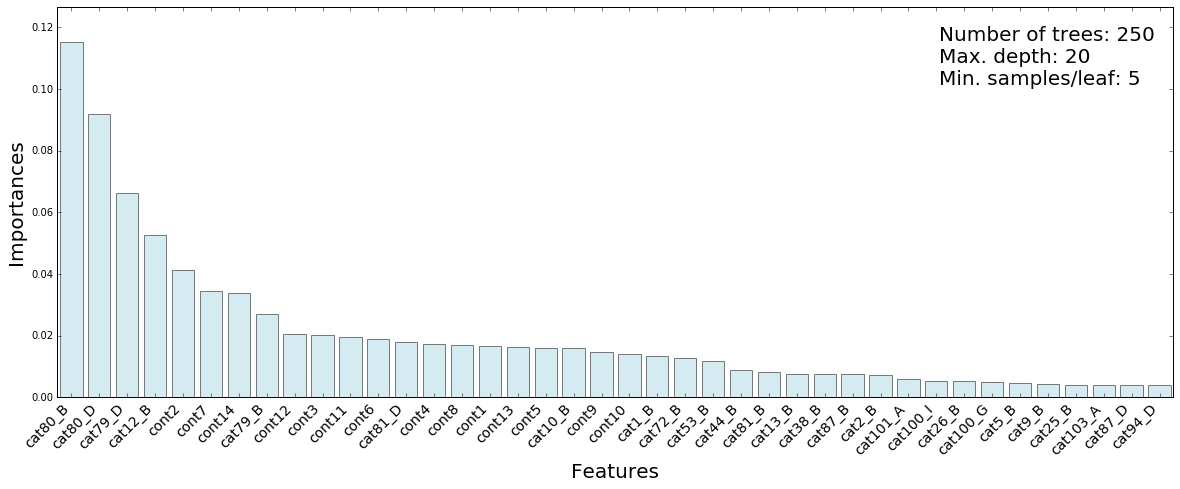


Results:
                               Train      Test
Number of instances =          15000,    15000
Mean y_true =                3018.47,  3047.77
Mean y_pred =                2802.41,  2823.07
Minimum y_pred =              682.29,   748.26
Maximum y_pred =            16191.58, 13833.70
Standard deviation y_true =  2910.82,  2924.47
Standard deviation y_pred =  1889.70,  1816.52
R^2 =                           0.65,     0.49
MAE =                         901.59,  1274.18, diff =   372.59
 


In [6]:
'''
Examine fit results.
'''
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Plot feature importances
importances = rfr.feature_importances_
print('Sum of importances: {0}'.format(sum(importances)))
indices     = np.argsort(importances)[::-1]
n_features  = min(40,indices.size)
bins        = np.arange(n_features)
x_labels    = np.array(predictors)[indices][:n_features]
maxHeight   = 1.10*max(importances)
fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(20, 7))
axes.bar(bins, importances[indices][:n_features], align="center", color="lightblue", alpha=0.5)
axes.set_xticks(bins)
axes.set_xticklabels(x_labels, ha="right", rotation=45., fontsize=14)
axes.set_xlim([-0.5,bins.size-0.5])
axes.set_xlabel("Features", fontsize=20)
axes.set_ylim([0.0, maxHeight])
axes.set_ylabel("Importances", fontsize=20)
axes.text(0.79, 0.80, 
          'Number of trees: {2}\nMax. depth: {0}\nMin. samples/leaf: {1}'.format(mxDepth, mnSleaf, nTrees),
          fontsize=20, transform=axes.transAxes)
plt.show()
fig.savefig('FeatureImportances'+fName+'.png', dpi=200, bbox_inches='tight')

# Make predictions on train and test set, and compute evaluation metric (MAE).
y_test_pred  = rfr.predict(X_test)
y_train_pred = rfr.predict(X_train)
MAE_train    = mean_absolute_error(y_train, y_train_pred)
MAE_test     = mean_absolute_error(y_test, y_test_pred)
dMAE         = MAE_test - MAE_train
r2_train     = r2_score(y_train, y_train_pred)
r2_test      = r2_score(y_test, y_test_pred)
print('\nResults:')
print('                               Train      Test')
print('Number of instances =         {0:6d},   {1:6d}'.format(len(y_train), len(y_test)))
print('Mean y_true =               {0:8.2f}, {1:8.2f}'.format(y_train.mean(), y_test.mean()))
print('Mean y_pred =               {0:8.2f}, {1:8.2f}'.format(y_train_pred.mean(), y_test_pred.mean()))
print('Minimum y_pred =            {0:8.2f}, {1:8.2f}'.format(y_train_pred.min(), y_test_pred.min()))
print('Maximum y_pred =            {0:8.2f}, {1:8.2f}'.format(y_train_pred.max(), y_test_pred.max()))
print('Standard deviation y_true = {0:8.2f}, {1:8.2f}'.format(y_train.std(), y_test.std()))
print('Standard deviation y_pred = {0:8.2f}, {1:8.2f}'.format(y_train_pred.std(), y_test_pred.std()))
print('R^2 =                       {0:8.2f}, {1:8.2f}'.format(r2_train, r2_test))
print('MAE =                       {0:8.2f}, {1:8.2f}, diff = {2:8.2f}'.format(MAE_train, MAE_test, dMAE))
print(' ')

# Save results in output file
with open('Results'+fName+'.txt', 'w') as outf:
    print >>outf, 'Logging time: {0}'.format(datetime.now().isoformat())
    print >>outf, 'Preprocessing version: {0}'.format(preProc)
    print >>outf, 'Algorithm: {0}'.format(rfr)
    print >>outf, '\nResults:'
    print >>outf, '                               Train      Test'
    print >>outf, 'Number of instances =         {0:6d},   {1:6d}'.format(len(y_train), len(y_test))
    print >>outf, 'Mean y_true =               {0:8.2f}, {1:8.2f}'.format(y_train.mean(), y_test.mean())
    print >>outf, 'Mean y_pred =               {0:8.2f}, {1:8.2f}'.format(y_train_pred.mean(), y_test_pred.mean())
    print >>outf, 'Minimum y_pred =            {0:8.2f}, {1:8.2f}'.format(y_train_pred.min(), y_test_pred.min())
    print >>outf, 'Maximum y_pred =            {0:8.2f}, {1:8.2f}'.format(y_train_pred.max(), y_test_pred.max())
    print >>outf, 'Standard deviation y_true = {0:8.2f}, {1:8.2f}'.format(y_train.std(), y_test.std())
    print >>outf, 'Standard deviation y_pred = {0:8.2f}, {1:8.2f}'.format(y_train_pred.std(), y_test_pred.std())
    print >>outf, 'R^2 =                       {0:8.2f}, {1:8.2f}'.format(r2_train, r2_test)
    print >>outf, 'MAE =                       {0:8.2f}, {1:8.2f}, diff = {2:8.2f}'.format(MAE_train, MAE_test, dMAE)

In [7]:
'''
Make predictions on remainder training set, and compute evaluation metric (MAE).
'''
# Convert pandas dataframe to its numpy representation, separating out the predictors.
X_remain      = df4.as_matrix(columns=predictors)
y_remain      = df4["loss"]
print('Shape of X_remain: {0}, y_remain: {1}'.format(X_remain.shape, y_remain.shape))

# Compute predictions and performance scores.
y_remain_pred = rfr.predict(X_remain)
r2_remain     = r2_score(y_remain, y_remain_pred)
MAE_remain    = mean_absolute_error(y_remain, y_remain_pred)

print('R^2 = {0:8.2f}'.format(r2_remain))
print('MAE = {0:8.2f}'.format(MAE_remain))

Shape of X_remain: (158318, 170), y_remain: (158318,)
R^2 =     0.47
MAE =  1263.37


In [8]:
'''
Make predictions on competition testing set and output to file.
'''
# Convert pandas dataframe to its numpy representation, separating out the predictors.
X_competition = df1.as_matrix(columns=predictors)
print('Shape of X_competition: {0}'.format(X_competition.shape))

# Compute predictions.
y_competition_pred = rfr.predict(X_competition)
df_competition = pd.Series(y_competition_pred, index=df1.index)

# Output to file.
path_to_file = 'data/rfr'+fName+'.csv'
try:
    df_competition.to_csv(path=path_to_file, sep=',', header=['loss'], index=True, index_label=['id'])
    print('Random forest predictions successfully saved to {0}'.format(path_to_file))
except:
    print('!Error saving random forest predictions to {0}'.format(path_to_file))

Shape of X_competition: (125546, 170)
Random forest predictions successfully saved to data/rfr_1_mxft1o3_15K_20_5_250.csv


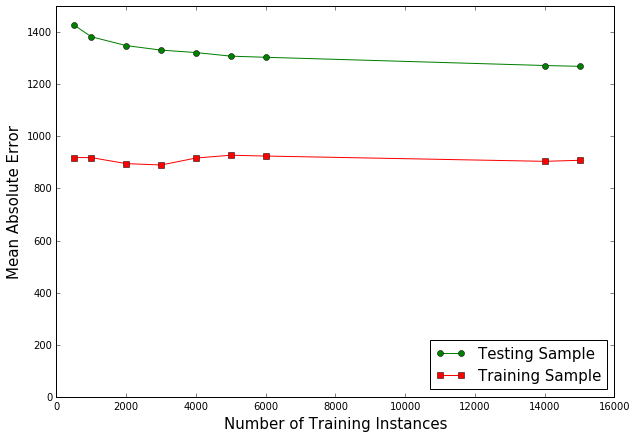

In [6]:
'''
Learning curve for preProcessing1 and the following algorithm:

   RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
   max_features=0.3333, max_leaf_nodes=None,
   min_impurity_split=1e-07, min_samples_leaf=5,
   min_samples_split=2, min_weight_fraction_leaf=0.0,
   n_estimators=250, n_jobs=1, oob_score=False, random_state=0,
   verbose=0, warm_start=False)
           
The number of training data samples goes from 500 to 15000, with missing 
points in between due to memory problems on the macbook pro.
The number of testing data samples is 15000.
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = [500,     1000,    2000,    3000,    4000,    5000,    6000,    14000,   15000]
mae_train = [918.82,  918.56,  895.46,  890.19,  916.95,  927.69,  924.57,  904.26,  908.22]
mae_test  = [1427.90, 1382.65, 1348.67, 1331.40, 1322.02, 1308.22, 1303.80, 1272.27, 1269.03]

fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axes.plot(n_samples, mae_test, 'go-', label='Testing Sample')
axes.plot(n_samples, mae_train, 'rs-', label='Training Sample')
axes.set_xlim([0.0, 16000.0])
axes.set_xlabel("Number of Training Instances", fontsize=15)
axes.set_ylim([0.0, 1500.0])
axes.set_ylabel("Mean Absolute Error", fontsize=15)
axes.legend(prop={'size': 15}, loc="lower right")
plt.show()

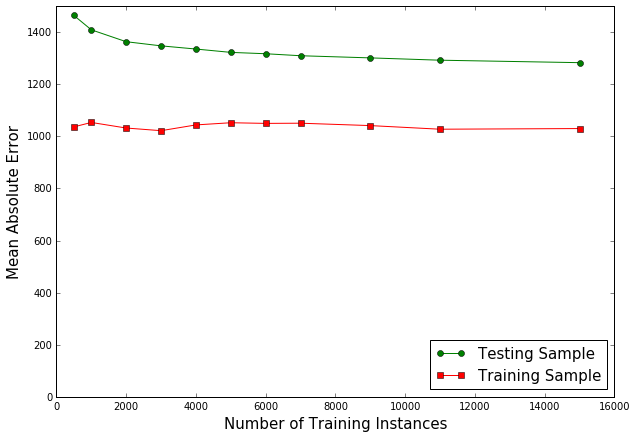

In [13]:
'''
Learning curve for preProcessing1 and the following algorithm:

   RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
   max_features='sqrt', max_leaf_nodes=None,
   min_impurity_split=1e-07, min_samples_leaf=5,
   min_samples_split=2, min_weight_fraction_leaf=0.0,
   n_estimators=250, n_jobs=1, oob_score=False, random_state=0,
   verbose=0, warm_start=False)
           
The number of training data samples goes from 1000 to 15000. 
The number of testing data samples is 15000.
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = [ 500,    1000,    2000,    3000,    4000,    5000,    6000,    7000,    9000,    11000,   15000]
mae_train = [1036.65, 1053.54, 1032.14, 1021.99, 1044.11, 1052.48, 1049.96, 1050.68, 1041.50, 1027.60, 1030.13]
mae_test  = [1464.47, 1409.28, 1363.63, 1347.71, 1335.48, 1322.66, 1317.43, 1309.78, 1301.51, 1292.62, 1283.17]

fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axes.plot(n_samples, mae_test, 'go-', label='Testing Sample')
axes.plot(n_samples, mae_train, 'rs-', label='Training Sample')
axes.set_xlim([0.0, 16000.0])
axes.set_xlabel("Number of Training Instances", fontsize=15)
axes.set_ylim([0.0, 1500.0])
axes.set_ylabel("Mean Absolute Error", fontsize=15)
axes.legend(prop={'size': 15}, loc="lower right")
plt.show()

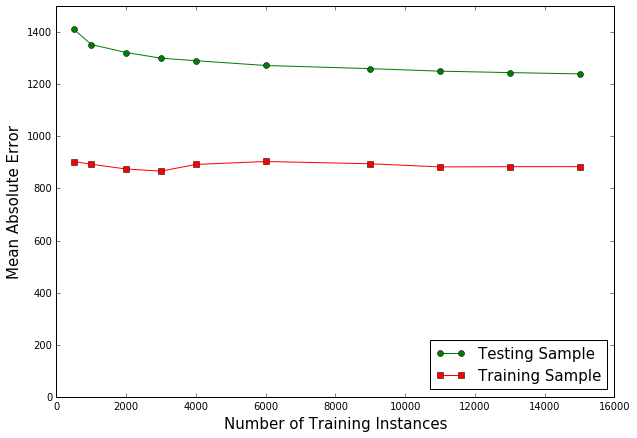

In [7]:
'''
Learning curve for preProcessing2 and the following algorithm:

   RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=20,
   max_features=0.3333, max_leaf_nodes=None,
   min_impurity_split=1e-07, min_samples_leaf=5,
   min_samples_split=2, min_weight_fraction_leaf=0.0,
   n_estimators=250, n_jobs=1, oob_score=False, random_state=0,
   verbose=0, warm_start=False)
           
The number of training data samples goes from 1000 to 15000. 
The number of testing data samples is 15000.
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = [ 500,    1000,    2000,    3000,    4000,    6000,    9000,    11000,    13000,   15000]
mae_train = [ 903.53,  893.10,  874.85,  866.69,  892.33,  903.61,  894.91,  882.84,  883.73,  883.84]
mae_test  = [1411.06, 1352.86, 1322.04, 1300.35, 1290.67, 1272.33, 1260.19, 1250.48, 1245.03, 1240.12]

fig, axes   = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axes.plot(n_samples, mae_test, 'go-', label='Testing Sample')
axes.plot(n_samples, mae_train, 'rs-', label='Training Sample')
axes.set_xlim([0.0, 16000.0])
axes.set_xlabel("Number of Training Instances", fontsize=15)
axes.set_ylim([0.0, 1500.0])
axes.set_ylabel("Mean Absolute Error", fontsize=15)
axes.legend(prop={'size': 15}, loc="lower right")
plt.show()